In [1]:
from enum import EnumType, Enum

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from numpy.f2py.auxfuncs import throw_error
from pettingzoo.mpe import simple_speaker_listener_v4
from scipy.ndimage import label


def make_env():
    env = simple_speaker_listener_v4.parallel_env(continuous_actions=False, render_mode="rgb_array", max_cycles=25)
    env.reset()
    return env

def make_env_human():
    env = simple_speaker_listener_v4.parallel_env(continuous_actions=False, render_mode="human", max_cycles=25)
    env.reset()
    return env

class DiscType(Enum):
    DECENTRALIZED = "decentralized"
    CENTRALIZED = "centralized"
    SINGLE = "single"


# Test the Environment

In [2]:
env = make_env()
observations, infos = env.reset()  # returns a dict
observations
# env.action_space

{'speaker_0': array([0.15, 0.65, 0.15], dtype=float32),
 'listener_0': array([ 0.        ,  0.        , -0.15203796, -1.5405881 , -0.65682936,
        -0.7432007 , -0.88544595, -0.20320949,  0.        ,  0.        ,
         0.        ], dtype=float32)}

**Here we can see that the global state is a concatenation of local observations**

In [3]:
env.state()

array([ 0.15      ,  0.65      ,  0.15      ,  0.        ,  0.        ,
       -0.15203796, -1.5405881 , -0.65682936, -0.7432007 , -0.88544595,
       -0.20320949,  0.        ,  0.        ,  0.        ], dtype=float32)

In [4]:
print("Agents:", env.agents)  # ['speaker_0', 'listener_0']

Agents: ['speaker_0', 'listener_0']


# Hyperparameters

In [5]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

USE_KFAC = False

DISC_TYPE = DiscType.DECENTRALIZED
total_training_runs = 3
training_epochs = 1500

centralized_learning_rate = 8e-5 # Try 3e-4
centralized_weight_decay = 0.2

decentralized_learning_rate = 1e-3
decentralized_weight_decay = 1e-3

policy_learning_rate = 1e-3
policy_learning_rate_kfac = 1e-2

value_learning_rate = 1e-3

num_expert_episodes = 200
BATCH_SIZE = 64
PPO_EPOCHS = 10
PPO_CLIP = 0.1
ENTROPY_COEF = 0

# Two layers network, applied for discriminator, policy and value network
all_hid_dim = 256




# Environment Variables

In [6]:
# Agent dimensions
speaker_obs_dim = 3     #[goal_id]
listener_obs_dim = 11 #[self_vel, all_landmark_rel_positions, communication]

speaker_act_dim = 3
listener_act_dim = 5 # [no_action, move_left, move_right, move_down, move_up]

all_agents = env.agents

obs_dims = {
    "speaker_0": speaker_obs_dim,
    "listener_0": listener_obs_dim
}

act_dims = {
    "speaker_0": speaker_act_dim,
    "listener_0": listener_act_dim
}

hid_dims = {
    "speaker_0": all_hid_dim,
    "listener_0": all_hid_dim
}

# Evaluated from 5000 expert episodes
expert_mean_reward = -39.53

# Expert Demonstrations
Load the expert policy from paper Inverse Factorized Soft Q-Learning for Cooperative Multi-agent Imitation Learning


In [7]:
# Load the expert policy
expert_policies = torch.jit.load("Expert_data/simple_speaker_listener.pt").to(device)
expert_policies.eval()

# Try to retrieve h_dim from the policy, fallback to 128
try:
    h_dim = expert_policies.h_dim
    print(f"Retrieved h_dim: {h_dim}")
except AttributeError:
    h_dim = 128  # From error message
    print("h_dim not accessible, using 128")

def expert_policy(obs, rnn_actor, deterministic=True):
    with torch.no_grad():
        # Convert observations to tensors
        obs_speaker = torch.FloatTensor(obs["speaker_0"]).to(device)
        obs_listener = torch.FloatTensor(obs["listener_0"]).to(device)
        # Pad speaker's observation (3) to match listener’s (11)
        obs_speaker_padded = torch.nn.functional.pad(obs_speaker, (0, 11 - 3))
        obs_batch = torch.stack([obs_speaker_padded, obs_listener], dim=0)

        # Define masks and available actions
        masks = torch.ones((2, 1), dtype=torch.bool, device=device)  # For 2 agents
        avails = torch.ones((2, 5), dtype=torch.float32, device=device)  # Assuming 5 actions per agent

        # Forward pass through the policy
        actions, _, new_rnn_actor = expert_policies._forward(
            obs_batch, rnn_actor, masks, avails, deterministic
        )
        actions_dict = {
            "speaker_0": actions[0].item(),
            "listener_0": actions[1].item()
        }
        return actions_dict, new_rnn_actor

def generate_expert_data_decentralized(num_episodes=50):
    env = make_env()  # Assuming this is defined elsewhere

    # TODO should change the data structure to actually store tuple (s,a)
    expert_data = {agent: {"states": [], "actions": []} for agent in env.agents}

    for _ in range(num_episodes):
        obs, _ = env.reset()
        # Initialize rnn_actor with shape (n_agents, 1, h_dim) on device
        rnn_actor = torch.zeros((2, 1, h_dim), device=device)

        while env.agents:
            actions, rnn_actor = expert_policy(obs, rnn_actor, deterministic=True)
            for agent in env.agents:
                expert_data[agent]["states"].append(obs[agent])
                expert_data[agent]["actions"].append(actions[agent])
                joint_state = env.state()
            obs, rewards, terminations, truncations, infos = env.step(actions)

    env.close()
    return expert_data

def convert_decentralized_data_to_centralized(decentralized_data):
    """
    Converts decentralized expert data to centralized format.

    Args:
        decentralized_data (dict): Decentralized expert data with the structure:
            {
                agent1: {"states": [state1, state2, ...], "actions": [action1, action2, ...]},
                agent2: {"states": [state1, state2, ...], "actions": [action1, action2, ...]},
                ...
            }
    Returns:
        dict: Centralized expert data with the structure:
            {
                "global_states": [state1, state2, ...],
                "joint_actions": [actions1, actions2, ...],
            }
    """
    centralized_expert_data = {
        "joint_states": [],  # Global states across all agents
        "joint_actions": []   # Joint actions per global state
    }

    # Ensure we use the same length throughout agents
    num_samples = len(decentralized_data[all_agents[0]]["states"])  # Extract the length from first agent

    for i in range(num_samples):
        # Combine states of all agents into a global state
        global_state = []
        for agent in decentralized_data:
            global_state.extend(decentralized_data[agent]["states"][i])
        centralized_expert_data["joint_states"].append(global_state)

        # Collect actions from all agents into a joint action
        joint_action = [decentralized_data[agent]["actions"][i] for agent in decentralized_data]
        centralized_expert_data["joint_actions"].append(joint_action)

    return centralized_expert_data


Retrieved h_dim: 128


In [8]:
import pickle

with open("Expert_data/simple_listener_speaker_25_timesteps_200_episodes.pickle", "rb") as f:
    decentralized_expert_data = pickle.load(f)

In [9]:
# Generate data
# decentralized_expert_data = generate_expert_data_decentralized(num_episodes=num_expert_episodes)

if DISC_TYPE == DiscType.CENTRALIZED:
    centralized_expert_data = convert_decentralized_data_to_centralized(decentralized_expert_data)


In [10]:
decentralized_expert_data["speaker_0"]["states"][0]

array([0.65, 0.15, 0.15], dtype=float32)

In [11]:
decentralized_expert_data["listener_0"]["states"][0]

array([ 0.        ,  0.        , -0.29658923,  0.28364152, -1.2993847 ,
       -0.32852152, -0.25230795,  0.21036412,  0.        ,  0.        ,
        0.        ], dtype=float32)

In [12]:
centralized_expert_data = convert_decentralized_data_to_centralized(decentralized_expert_data)
centralized_expert_data["joint_states"][0]

[np.float32(0.65),
 np.float32(0.15),
 np.float32(0.15),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(-0.29658923),
 np.float32(0.28364152),
 np.float32(-1.2993847),
 np.float32(-0.32852152),
 np.float32(-0.25230795),
 np.float32(0.21036412),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0)]

Shape Checking

In [13]:
if DISC_TYPE == DiscType.CENTRALIZED:
    expert_states = torch.FloatTensor(centralized_expert_data["joint_states"]).to(device)
    expert_actions = torch.LongTensor(centralized_expert_data["joint_actions"]).to(device)
elif DISC_TYPE == DiscType.DECENTRALIZED:
    agent = "speaker_0"
    expert_states = torch.FloatTensor(decentralized_expert_data[agent]["states"]).to(device)
    expert_actions = torch.LongTensor(decentralized_expert_data[agent]["actions"]).to(device)


In [14]:
expert_states.shape

torch.Size([4800, 14])

In [15]:
expert_actions.shape

torch.Size([4800, 2])

In [16]:
expert_actions.cpu().numpy()

array([[2, 1],
       [2, 1],
       [2, 1],
       ...,
       [0, 0],
       [0, 1],
       [0, 2]])

### Evaluate the Expert Policy

In [17]:
def evaluate_policy_for_expert(policy_func, num_episodes=50, threshold=0.1, h_dim=128, device=device):
    env = make_env()
    avg_rewards = []

    for episode in range(num_episodes):
        obs, _ = env.reset()
        total_reward = 0
        rnn_actor = torch.zeros((2, 1, h_dim), device=device)

        while env.agents:
            actions, rnn_actor = policy_func(obs, rnn_actor, deterministic=True)
            obs, rewards, done, _, _ = env.step(actions)
            total_reward += sum(rewards.values())

        avg_rewards.append(total_reward)

    env.close()
    return {
        "avg_reward": np.mean(avg_rewards),
    }


In [18]:
# Evaluate the expert policy
# expert_eval = evaluate_policy_for_expert(expert_policy, num_episodes=20)
# print("Expert Policy Evaluation:", expert_eval)


# Policy Evaluation Function

In [19]:
def learned_policy(policies, obs, device=device):
    """
    Retrieves actions from the learned policy networks for both agents based on observations.

    Args:
        policies (dict): Dictionary mapping agent names to their Policy network instances.
        obs (dict): Dictionary of observations for each agent.
        device (str): Device to perform computations on ("cuda:0" or "cpu").

    Returns:
        dict: Dictionary mapping agent names to selected actions.
    """
    actions = {}
    for agent in obs:
        policy = policies[agent]
        # Convert observation to tensor and move to device
        obs_tensor = torch.FloatTensor(obs[agent]).to(device)
        with torch.no_grad():
            # Get action probabilities from the policy network
            action_probs = policy(obs_tensor)
            # Select the action with the highest probability
            action = torch.argmax(action_probs).item()
        actions[agent] = action
    return actions

def evaluate_policy_for_training(policies, num_episodes=50, threshold=0.1, device=device):
    """
    Evaluates the performance of learned policies over multiple episodes.

    Args:
        policies (dict): Dictionary of Policy networks for each agent.
        num_episodes (int): Number of episodes to run for evaluation (default: 50).
        threshold (float): Distance threshold to determine success (default: 0.1).
        device (str): Device to perform computations on (default: "cuda:0" or "cpu").

    Returns:
        dict: Dictionary containing evaluation metrics:
              - "success_rate": Mean success rate across episodes.
              - "avg_reward": Mean total reward per episode.
              - "avg_steps": Mean number of steps per episode.
    """
    # Set to evaluation mode to switch off dropout
    for policy in policies.values():
        policy.eval()

    # Initialize the environment
    env = make_env()
    avg_rewards = []

    # Run evaluation over specified number of episodes
    for episode in range(num_episodes):
        obs, _ = env.reset()
        total_reward = 0

        # Run the episode
        while env.agents:
            # Get actions using the learned policy
            actions = learned_policy(policies, obs, device)
            # Step the environment
            obs, rewards, done, _, _ = env.step(actions)
            total_reward += sum(rewards.values())  # Sum rewards from both agents

        avg_rewards.append(total_reward)

    # Clean up environment resources
    env.close()

    # Compute and return average metrics
    return {
        "avg_reward": np.mean(avg_rewards),
    }

# MAGAIL Training

## Define MAGAIL Networks

In [20]:
import torch
import torch.nn as nn

# Define the Xavier initialization function
def init_weights_xavier(module):
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            nn.init.zeros_(module.bias)

def init_weights(module):
    if isinstance(module, nn.Linear):
        nn.init.normal_(module.weight, mean=0.0, std=0.02)
        if module.bias is not None:
            nn.init.zeros_(module.bias)

# Policy Networks (one per agent)
class Policy(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, act_dim),
            nn.Softmax(dim=-1)
        )
        self.apply(init_weights)
    
    def forward(self, x):
        return self.net(x)

# Discriminator Networks (one per agent)
# Output the probability of (s,a) Coming from the EXPERT
class Discriminator(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim + act_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid())
        self.apply(init_weights)
    
    def forward(self, state, action):
        return self.net(torch.cat([state, action], dim=-1))
    
# Value Network as baseline
class ValueNet(nn.Module):
    def __init__(self, obs_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        self.apply(init_weights)
    
    def forward(self, x):
        return self.net(x)


def init_networks():
    # Initialize Networks

    if DISC_TYPE == DiscType.CENTRALIZED:
        # For Discriminator the output is a single value
        joint_state_dim = sum(obs_dims.values())  # Global state dimension
        joint_action_dim = sum(act_dims.values())
        discriminator_centralized = Discriminator(obs_dim=joint_state_dim, act_dim=joint_action_dim, hidden_dim=hid_dims[all_agents[0]]).to(device)

    elif DISC_TYPE == DiscType.DECENTRALIZED:
        discriminators = {
            a: Discriminator(obs_dim=obs_dims[a], act_dim=act_dims[a], hidden_dim=hid_dims[a]).to(device)
            for a in all_agents
        }

    # Initialize value networks to reduce variance (actor critic)

    policies = {
        a: Policy(obs_dim=obs_dims[a], act_dim=act_dims[a], hidden_dim=hid_dims[a]).to(device)
        for a in all_agents
    }

    if DISC_TYPE == DiscType.CENTRALIZED:
        joint_state_dim = sum(obs_dims.values())  # Global state dimension
        value_nets = {}
        for agent in all_agents:
            value_nets[agent] = ValueNet(joint_state_dim, hid_dims[agent]).to(device)
    elif DISC_TYPE == DiscType.DECENTRALIZED:
        value_nets = {
            agent: ValueNet(obs_dims[agent], hid_dims[agent]).to(device)
            for agent in all_agents
        }

    if DISC_TYPE == DiscType.CENTRALIZED:
        return discriminator_centralized, value_nets, policies
    elif DISC_TYPE == DiscType.DECENTRALIZED:
        return discriminators, value_nets, policies

In [21]:
sum(act_dims.values())

8

## Training MAGAIL Loop

In [22]:
from torch_kfac import KFAC

def train_magail(expert_data, num_epochs=1000, batch_size=32):


    # TODO Change this into an object
    training_data = {
        'expert_rewards': [],
        'episode_rewards': [],
        'generator_rewards': [],
        'advantages': [],
        'value_estimates': [],
        'policy_losses': [],
        'disc_real_prob': [],
        'disc_fake_prob': []
    }

    discriminator, value_nets, policies = init_networks()
    optimizers = init_optimizers(discriminator, value_nets, policies)

    for epoch in range(num_epochs):

        decentralized_policy_data = collect_policy_trajectories(policies, batch_size=batch_size)
        centralized_policy_data = convert_decentralized_data_to_centralized(decentralized_policy_data)

        # --- Update discriminators ---
        real_prob, fake_prob = update_discriminators(discriminator, centralized_policy_data, decentralized_policy_data, optimizers, batch_size)

        # --- Update policies and value (Actor Critic) ---
        generator_rewards, advantages, value_loss, policy_loss = update_policies(discriminator, value_nets, policies, decentralized_policy_data, centralized_policy_data, optimizers, batch_size)

        # Diagnostic
        record_and_print_diagnostics(epoch, policies, training_data, generator_rewards, advantages, value_loss, policy_loss, real_prob, fake_prob)


    env.close()

    return training_data

def init_optimizers(discriminator, value_nets, policies):
    if USE_KFAC:
        optimizers = {
        agent: {
            # Replace Adam with KFAC for policy
            "policy": KFAC(
                policies[agent],
                learning_rate=policy_learning_rate_kfac,  # Typically larger than Adam
                damping=1e-2,           # Added to the curvature approximation (Fisher matrix) for numerical stability.  lower damping → lower learning_rate
                momentum=0.95,# Similar to Nesterov momentum
                momentum_type='regular',
                norm_constraint=0.002,       # For KL ≤ 0.001
                cov_ema_decay=0.95,
                adapt_damping=True,     # Let KFAC adjust damping
                update_cov_manually=True  # Required for control
            ),
            "value": torch.optim.Adam(value_nets[agent].parameters(), lr=value_learning_rate)
            } for agent in all_agents
        }

    else:
        optimizers = {
        agent: {
            # Replace Adam with KFAC for policy
            "policy": torch.optim.Adam(policies[agent].parameters(), lr=policy_learning_rate),
            "value": torch.optim.Adam(value_nets[agent].parameters(), lr=value_learning_rate)
            } for agent in all_agents
        }

    if DISC_TYPE == DiscType.CENTRALIZED:
        optimizers["disc"] = torch.optim.Adam(discriminator.parameters(), lr=centralized_learning_rate, weight_decay=centralized_weight_decay)
    elif DISC_TYPE == DiscType.DECENTRALIZED:
        for agent in all_agents:
            optimizers[agent]["disc"] = torch.optim.Adam(discriminator[agent].parameters(), lr=decentralized_learning_rate, weight_decay=decentralized_weight_decay)

    # for agent in all_agents:
    #     policies[agent].to(device)
    return optimizers

#region Data sample and processing

def collect_policy_trajectories(policies, batch_size=32):
    env = make_env()
    policy_data = {
        agent: {
            "states": [],
            "actions": [],
            "log_prob": [],
            "reward": [],
            "next_state": []
        }
        for agent in env.agents
    }
    obs, _ = env.reset()
    agent = env.agents[0]
    policy_data_length = len(policy_data[agent]["states"])
    while policy_data_length < batch_size:
        while env.agents:
            actions = {}
            for agent in env.agents:
                with torch.no_grad():
                    obs_tensor = torch.FloatTensor(obs[agent]).to(device)
                    action_probs = policies[agent](obs_tensor)

                # Add numerical stability checks
                if torch.isnan(action_probs).any() or (action_probs < 0).any():
                    print("Invalid action probabilities detected!")
                    action_probs = torch.softmax(action_probs, dim=-1)  # Force normalization
                    action_probs = torch.clamp(action_probs, min=1e-5, max=1-1e-5)

                # Simpling by probability - ensure exploration
                # Similar with Epsilon-Greedy, but used in policy-based algorithms. Epsilon-Greedy is in valued based
                action = torch.multinomial(action_probs, 1).item()
                actions[agent] = action

                # Data collection
                policy_data[agent]["states"].append(obs[agent])
                policy_data[agent]["actions"].append(action)
                log_prob = torch.log(action_probs[action].clamp(min=1e-8))
                policy_data[agent]["log_prob"].append(log_prob)

            obs, rewards, terminations, truncations, infos= env.step(actions)

            for agent in env.agents:

                # with torch.no_grad():
                    ## Decentralized
                    # TODO encode action
                    # reward = torch.log(discriminators[agent](torch.FloatTensor(obs[agent]).to(device), torch.LongTensor(actions[agent]).to(device)))

                # policy_data[agent]["reward"].append(reward)

                if not terminations[agent]:
                    policy_data[agent]["next_state"].append(obs[agent])
                else:
                    policy_data[agent]["next_state"].append(None)

        env.reset()
        policy_data_length = len(policy_data[agent]["states"])

    return policy_data

def sample_batch_state_action_pairs(disc_type : DiscType, data, batch_size=32, agent = None, include_log_prob=False):

    # Sample Expert data
    if disc_type == DiscType.CENTRALIZED:
        states = torch.FloatTensor(data["joint_states"]).to(device)
        actions = torch.LongTensor(data["joint_actions"]).to(device)
        if include_log_prob:
            log_probs = torch.stack(data[agent]["log_prob"]).to(device)
    elif disc_type == DiscType.DECENTRALIZED:
        if not agent:
            throw_error("Please specify the agent in DECENTRALIZED mode")
        states = torch.FloatTensor(data[agent]["states"]).to(device)
        actions = torch.LongTensor(data[agent]["actions"]).to(device)
        if include_log_prob:
            log_probs = torch.stack(data[agent]["log_prob"]).to(device)

    # Make sure the (s,a) order does not change
    sample_indices = np.random.choice(len(states), batch_size, replace=False)
    batch_states = states[sample_indices]
    batch_actions = actions[sample_indices]

    if include_log_prob:
        batch_old_log_probs = log_probs[sample_indices]
        return batch_states, batch_actions, batch_old_log_probs

    return batch_states, batch_actions

def encode_joint_actions(joint_actions):
    '''
    Convert joint actions to one-hot
    action [2,4] => [0,0,1,0,0,0,0,1] joint actions one hot
    action [2,3] => [0,0,1,0,0,0,1,0]
    :param joint_actions:
    :return:
    '''
    encoded = []
    for ja in joint_actions:
        speaker_act = torch.nn.functional.one_hot(torch.tensor(ja[0]), speaker_act_dim)
        listener_act = torch.nn.functional.one_hot(torch.tensor(ja[1]), listener_act_dim)
        encoded.append(torch.cat([speaker_act, listener_act]))
    return torch.stack(encoded).to(device)
#endregion

#region discriminators Networks

def update_discriminators(discriminator, centralized_policy_data, decentralized_policy_data, optimizers, batch_size):
    if DISC_TYPE == DiscType.CENTRALIZED:
        real_prob, fake_prob = update_discriminators_centralized(discriminator, centralized_expert_data, centralized_policy_data, optimizers, batch_size)
    elif DISC_TYPE == DiscType.DECENTRALIZED:
        for agent in all_agents:
           real_prob, fake_prob =  update_discriminators_decentralized(discriminator, agent, decentralized_expert_data, decentralized_policy_data, optimizers, batch_size)

    return real_prob, fake_prob

def update_discriminators_decentralized(discriminator, agent, expert_data, policy_data, optimizers, batch_size):
    # Sample batch from dataset
    expert_states, expert_actions = sample_batch_state_action_pairs(DISC_TYPE, expert_data, batch_size, agent)
    policy_states, policy_actions = sample_batch_state_action_pairs(DISC_TYPE, policy_data, batch_size, agent)

    # One-hot encode actions (different for speaker/listener)
    num_classes = act_dims[agent]
    expert_actions_onehot = torch.nn.functional.one_hot(expert_actions, num_classes=num_classes).float().to(device)
    policy_actions_onehot = torch.nn.functional.one_hot(policy_actions, num_classes=num_classes).float().to(device)

    expert_prob, policy_prob = discriminator_backward(discriminator[agent], optimizers[agent]["disc"], expert_states, expert_actions_onehot, policy_states, policy_actions_onehot)

    return expert_prob, policy_prob

def update_discriminators_centralized(discriminator, centralized_expert_data, centralized_policy_data, optimizers, batch_size):
    # Centralized update
    # Shape [batch_size, 14], [batch_size, 2]
    expert_joint_states, expert_joint_actions = sample_batch_state_action_pairs(DISC_TYPE, centralized_expert_data, batch_size)
    policy_joint_states, policy_joint_actions = sample_batch_state_action_pairs(DISC_TYPE, centralized_policy_data, batch_size)

    expert_joint_actions_onehot = encode_joint_actions(expert_joint_actions)
    policy_joint_actions_onehot = encode_joint_actions(policy_joint_actions)

    expert_prob, policy_prob = discriminator_backward(discriminator, optimizers["disc"], expert_joint_states, expert_joint_actions_onehot, policy_joint_states, policy_joint_actions_onehot)

    return expert_prob, policy_prob

def discriminator_backward(discriminator, discriminator_optimizer, expert_states, expert_actions_onehot, policy_states, policy_actions_onehot):

    # Discriminator loss
    # max[log(D(expert)) + log(1 - D(policy))] => min[-log(D(expert)) - log(1 - D(policy))],

    expert_prob = discriminator(expert_states, expert_actions_onehot)
    policy_prob = discriminator(policy_states, policy_actions_onehot)

    real_loss = -torch.log(expert_prob).mean()
    fake_loss = -torch.log(1 - policy_prob).mean()
    disc_loss = real_loss + fake_loss

    discriminator_optimizer.zero_grad()
    disc_loss.backward()
    discriminator_optimizer.step()

    return expert_prob, policy_prob

#endregion

#region Policy and Value Networks
def update_policies(discriminator, value_nets, policies, decentralized_policy_data, centralized_policy_data, optimizers, batch_size):
    for agent in all_agents:
        if USE_KFAC:
            optimizers[agent]["policy"].update_cov()
        if DISC_TYPE == DiscType.CENTRALIZED:
            generator_rewards, advantages, value_loss, policy_loss = update_policies_centralized(discriminator, value_nets, policies, agent, decentralized_policy_data, centralized_policy_data, optimizers, batch_size)
        elif DISC_TYPE == DiscType.DECENTRALIZED:
            generator_rewards, advantages, value_loss, policy_loss = update_policies_decentralized(discriminator, value_nets, policies, agent, decentralized_policy_data, optimizers, batch_size)

    return  generator_rewards, advantages, value_loss, policy_loss

def update_policies_centralized(discriminator, value_nets, policies, agent, decentralized_policy_data, centralized_policy_data, optimizers, batch_size):

    # Centralized data
    policy_joint_states, policy_joint_actions = sample_batch_state_action_pairs(DISC_TYPE, centralized_policy_data, batch_size)
    policy_joint_actions_onehot = encode_joint_actions(policy_joint_actions)# actions [0,0] => [1,0,0,1,0,0,0,0]

    # decentralized data
    policy_states, policy_actions, old_log_probs = sample_batch_state_action_pairs(disc_type= DiscType.DECENTRALIZED, data=decentralized_policy_data, batch_size=batch_size, agent=agent, include_log_prob=True)

    # Adversarial reward: log(D(s,a))
    # D(s,a) How much the descrimiator think it is from the expert, and we wanna maximize this reward
    with torch.no_grad():

        # MAGAIL paper section 4.1
        # Implicitly, Di - discriminators plays the role of a reward function for the generator,which in turn attempts to train the agent to maximize its reward thus fooling the discriminator
        # In centralized case, this input the joint state actions
        generator_rewards = torch.log(discriminator(policy_joint_states, policy_joint_actions_onehot)) # Shape [batch_size,1]

        # Compute value baseline
        values = value_nets[agent](policy_joint_states) # Shape [batch_size,1]


    advantages, policy_loss = update_value_and_policy_network(policies, agent, optimizers, generator_rewards, values, policy_states, policy_actions, old_log_probs)
    return generator_rewards, advantages, values.mean(), policy_loss

def update_policies_decentralized(discriminator, value_nets, policies, agent, policy_data, optimizers, batch_size):
    policy_states, policy_actions, old_log_probs = sample_batch_state_action_pairs(disc_type= DiscType.DECENTRALIZED, data=policy_data, batch_size=batch_size, agent=agent, include_log_prob=True)
    # One-hot encode actions (different for speaker/listener)
    num_classes = act_dims[agent]
    policy_actions_onehot = torch.nn.functional.one_hot(policy_actions, num_classes=num_classes).float().to(device)

    # Adversarial reward: log(D(s,a))
    # D(s,a) How much the descrimiator think it is from the expert, and we wanna maximize this reward
    with torch.no_grad():

        # MAGAIL paper section 4.1
        # Implicitly, Di - discriminators plays the role of a reward function for the generator,which in turn attempts to train the agent to maximize its reward thus fooling the discriminator
        # In decentralized case, this input the local observations and agent's actions
        generator_rewards = torch.log(discriminator[agent](policy_states, policy_actions_onehot))

        # Compute value baseline
        values = value_nets[agent](policy_states)

    advantages, policy_loss = update_value_and_policy_network(policies, agent, optimizers, generator_rewards, values, policy_states, policy_actions, old_log_probs)

    return generator_rewards, advantages, values.mean(), policy_loss

def update_value_and_policy_network(policies, agent, optimizers, generator_rewards, values, decentralized_policy_states, decentralized_policy_actions, old_log_probs):

    # Compute advantages
    # TD error: (actual reward - estimate(baseline))
    # Then use this advantage as reward/reinforce signal
    # squeeze() function removes "trivia" dim (dimensions of size 1) form tensor's shape
    # Here values shape [batch_size, 1] => values.squeeze() => [batch_size] it become a vector
    # It can only apply on dimensions of size 1, eg: policy_actions shape [batch_size,2] policy_actions.squeeze().shape is till [batch_size,2]
    advantages = generator_rewards - values # Shape [batch_size,1]
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8) # Normalize advantage

    # Update value network (MSE Loss)
    value_loss = (advantages).pow(2).mean()
    # Should always clear the gradient before update
    value_loss.requires_grad = True
    optimizers[agent]["value"].zero_grad()
    value_loss.backward()
    optimizers[agent]["value"].step()

    if USE_KFAC:
        # --- KFAC Policy gradient ---
        policy_optimizer = optimizers[agent]["policy"]

        # Track forward pass
        with policy_optimizer.track_forward():
            action_probs = policies[agent](decentralized_policy_states)
            log_probs = torch.log(action_probs.gather(1, decentralized_policy_actions.unsqueeze(1)))
            policy_loss = -(log_probs * advantages.detach()).mean()

        # Track backward pass
        with policy_optimizer.track_backward():
            policy_loss.backward()

        # KFAC update steps
        policy_optimizer.update_cov()  # Update curvature approximation
        policy_optimizer.step(loss=policy_loss)  # Precondition gradients

        # In KFAC, the gradient can explode, causing softmax logits to underflow/overflow
        # Use clipping as a safeguard
        torch.nn.utils.clip_grad_norm_(policies[agent].parameters(), max_norm=0.5)
    else:

        # PPO Policy update with multiple epochs
        policy_loss_total = 0.0
        for _ in range(PPO_EPOCHS):
            action_probs = policies[agent](decentralized_policy_states)  # [batch_size, act_dim]
            new_log_probs = torch.log(
                action_probs.gather(1, decentralized_policy_actions.unsqueeze(1)).clamp(min=1e-8)
            ).squeeze(1)  # [batch_size]

            # Instead of directly compute new_log_probs/old_log_probs, we took log and use e to ensure Numerical Stability
            # Cuz in Deep RL action probs can be very small.
            ratio = torch.exp(new_log_probs - old_log_probs)  # [batch_size]

            # for r in ratio:
            #     if r > 1 + PPO_CLIP or r < 1 - PPO_CLIP:
            #         print(f"PPO ratio clipped!! : {r}")

            # TODO While this kind of clipping goes a long way towards ensuring reasonable policy updates, it is still possible to end up with a new policy which is too far from the old policy, and there are a bunch of tricks used by different PPO implementations to stave this off. In our implementation here, we use a particularly simple method: early stopping. If the mean KL-divergence of the new policy from the old grows beyond a threshold, we stop taking gradient steps.

            # PPO clipped surrogate objective
            surr1 = ratio * advantages.detach().squeeze()
            surr2 = torch.clamp(ratio, 1 - PPO_CLIP, 1 + PPO_CLIP) * advantages.detach().squeeze()
            policy_loss = -torch.min(surr1, surr2).mean()

            # Add entropy bonus for exploration
            # entropy = -torch.sum(action_probs * torch.log(action_probs.clamp(min=1e-8)), dim=-1).mean()
            # policy_loss = policy_loss - ENTROPY_COEF * entropy

            optimizers[agent]["policy"].zero_grad()
            policy_loss.backward()
            torch.nn.utils.clip_grad_norm_(policies[agent].parameters(), max_norm=0.5)  # Gradient clipping
            optimizers[agent]["policy"].step()

            policy_loss_total += policy_loss.item()

        policy_loss_avg = policy_loss_total / PPO_EPOCHS

    return advantages, torch.tensor(policy_loss_avg)

#endregion

def record_and_print_diagnostics(epoch, policies, training_data, generator_rewards, advantages, value_loss, policy_loss, real_prob, fake_prob):
    training_data["generator_rewards"].append(generator_rewards.detach().cpu().numpy().mean())
    training_data["advantages"].append(advantages.detach().cpu().numpy().mean())
    training_data["value_estimates"].append(value_loss.detach().cpu().numpy().mean())
    training_data["policy_losses"].append(policy_loss.detach().cpu().numpy().mean())

    training_data["disc_real_prob"].append(real_prob.detach().cpu().numpy().mean())
    training_data["disc_fake_prob"].append(fake_prob.detach().cpu().numpy().mean())

    if epoch % 50 == 0:
        print("------------------------------------------------------")
        training_eval_stats = evaluate_policy_for_training(policies, num_episodes=20)
        print(f"Epoch {epoch}: Avg Reward={training_eval_stats['avg_reward']:.2f}")
        training_data["episode_rewards"].append(training_eval_stats["avg_reward"])

        # expert_eval = evaluate_policy_for_expert(expert_policy, num_episodes=20)
        training_data["expert_rewards"].append(expert_mean_reward)
        print(f"Expert Policy: Avg Reward={expert_mean_reward}")

        mean_generator_rewards = np.mean(training_data["generator_rewards"][-50:])
        mean_advantages = np.mean(training_data["generator_rewards"][-50:])
        mean_value_losses = np.mean(training_data["value_estimates"][-50:])
        mean_policy_losses = np.mean(training_data["policy_losses"][-50:])
        mean_disc_real_prob = np.mean(training_data["disc_real_prob"][-50:])
        mean_disc_fake_prob = np.mean(training_data["disc_fake_prob"][-50:])

        print(f"Epoch {epoch}: disc_real_prob={mean_disc_real_prob:.2f}, disc_fake_prob={mean_disc_fake_prob:.2f}")



# train_magail(decentralized_expert_data, num_epochs=10, batch_size=BATCH_SIZE)


## Training

In [23]:
import pandas as pd
import os

folder_path = "Training_Data"

def save_training_data(run_id, training_data):
    epochs = range(0, len(training_data["episode_rewards"]) * 50, 50)

    def compute_mean(array):
        # Compute windowed means for every 50 epochs (non-overlapping)
        window_size = 50
        window_means = [np.mean(array[i:i+window_size])
                        for i in range(0, len(array), window_size)]
        # Prepend the first original value as per request
        window_means[0] = array[0]

        return window_means

    df = pd.DataFrame({
        'epoch': epochs,
        'expert_rewards': training_data['expert_rewards'],
        'episode_rewards': training_data['episode_rewards'],
        'generator_rewards': compute_mean(training_data['generator_rewards']),
        'advantages': compute_mean(training_data['advantages']),
        'value_estimates': compute_mean(training_data['value_estimates']),
        'policy_losses': compute_mean(training_data['policy_losses']),
        'disc_real_prob': compute_mean(training_data['disc_real_prob']),
        'disc_fake_prob': compute_mean(training_data['disc_fake_prob'])
    })

    df.to_csv(os.path.join(folder_path, f'run_{run_id}.csv'), index=False)  # run_id is a unique identifier for the run

for run_id in range(total_training_runs):
    training_data = train_magail(decentralized_expert_data, num_epochs=training_epochs, batch_size=BATCH_SIZE)
    save_training_data(run_id, training_data)
    print(f"***Finished training run {run_id}***")


C:\Users\wangy\AppData\Local\Temp\ipykernel_90704\560524109.py:179: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speaker_act = torch.nn.functional.one_hot(torch.tensor(ja[0]), speaker_act_dim)
C:\Users\wangy\AppData\Local\Temp\ipykernel_90704\560524109.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  listener_act = torch.nn.functional.one_hot(torch.tensor(ja[1]), listener_act_dim)
C:\Users\wangy\AppData\Local\Temp\ipykernel_90704\560524109.py:153: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_wo

------------------------------------------------------
Epoch 0: Avg Reward=-328.43
Expert Policy: Avg Reward=-39.53
Epoch 0: disc_real_prob=0.50, disc_fake_prob=0.50
------------------------------------------------------
Epoch 50: Avg Reward=-112.38
Expert Policy: Avg Reward=-39.53
Epoch 50: disc_real_prob=0.50, disc_fake_prob=0.50
------------------------------------------------------
Epoch 100: Avg Reward=-123.84
Expert Policy: Avg Reward=-39.53
Epoch 100: disc_real_prob=0.50, disc_fake_prob=0.49
------------------------------------------------------
Epoch 150: Avg Reward=-259.93
Expert Policy: Avg Reward=-39.53
Epoch 150: disc_real_prob=0.50, disc_fake_prob=0.49
------------------------------------------------------
Epoch 200: Avg Reward=-354.93
Expert Policy: Avg Reward=-39.53
Epoch 200: disc_real_prob=0.50, disc_fake_prob=0.48
------------------------------------------------------
Epoch 250: Avg Reward=-380.97
Expert Policy: Avg Reward=-39.53
Epoch 250: disc_real_prob=0.51, disc_f

# Plotting Training Results

Aggregate Data

In [24]:
import pandas as pd
import os
import glob
folder_path = "Training_Data"

# Read all run files
files = glob.glob(os.path.join(folder_path, 'run_*.csv'))
dfs = [pd.read_csv(file) for file in files]
combined_df = pd.concat(dfs, ignore_index=True)

# Compute the mean per epoch
avg_df = combined_df.groupby('epoch').mean()
std_df = combined_df.groupby('epoch').std()



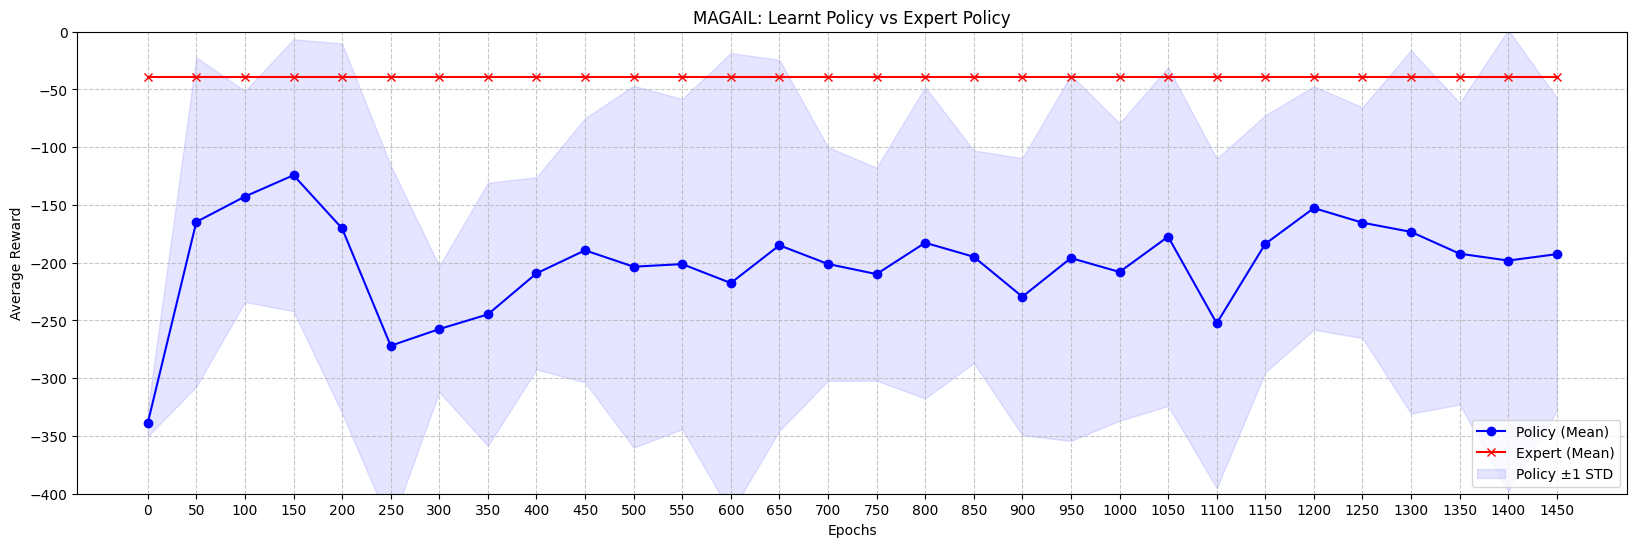

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime


epochs = range(0, len(avg_df["episode_rewards"]) * 50, 50)  # X-axis: epochs (0, 50, 100, ...)


# Create the plot
plt.figure(figsize=(20, 6))
plt.plot(epochs, avg_df["episode_rewards"], label='Policy (Mean)', marker='o', color='blue')
plt.plot(epochs, avg_df["expert_rewards"], label='Expert (Mean)', marker='x', color='red')

# Plot shaded areas for standard deviation
plt.fill_between(epochs,
                 avg_df["episode_rewards"] - std_df["episode_rewards"],
                 avg_df["episode_rewards"] + std_df["episode_rewards"],
                 alpha=0.1, color='blue', label='Policy ±1 STD')

# Customize the plot
plt.xlabel('Epochs')
plt.ylabel('Average Reward')
plt.title('MAGAIL: Learnt Policy vs Expert Policy')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.xticks(epochs)  # Show epoch numbers on x-axis

# Fix the y-axis
plt.ylim(-400, 0)

# Save plot
os.makedirs("plots", exist_ok=True)
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")
save_path = f"plots/magail_{timestamp}.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')


# Display the plot
plt.show()

In [26]:
# Create the plot
def plot_dianostics(array_mean, array_std, title):
    plt.figure(figsize=(20, 6))

    window_size = 50

    # Plot the window-averaged data
    plt.plot(range(0, len(array_mean) * window_size, window_size), array_mean, color='blue', marker='o', linewidth=2)

    # Plot shaded areas for standard deviation
    plt.fill_between(epochs,
                     array_mean - array_std,
                     array_mean + array_std,
                     alpha=0.05, color='blue', label='Policy ±1 STD')

    # Customize the plot
    plt.xlabel('Epochs')
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.xticks(epochs)  # Show epoch numbers on x-axis

    # Fix the y-axis
    plt.ylim(-1, 1)

    # Display the plot
    plt.show()


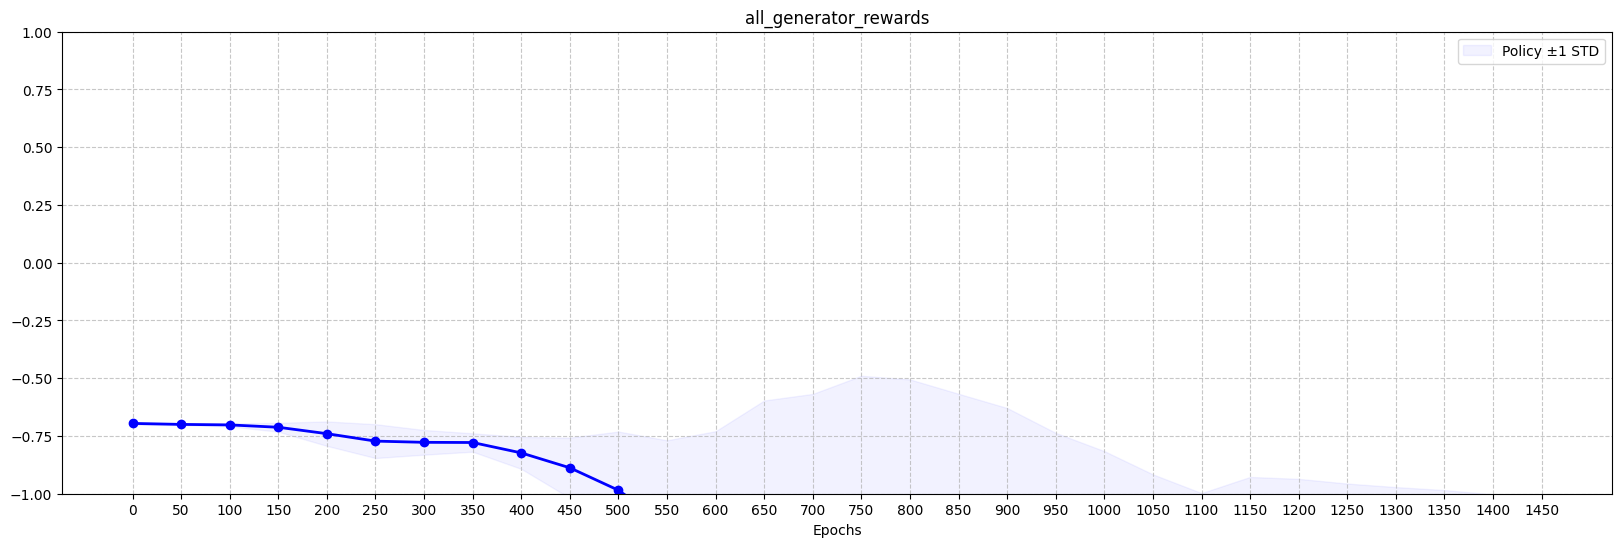

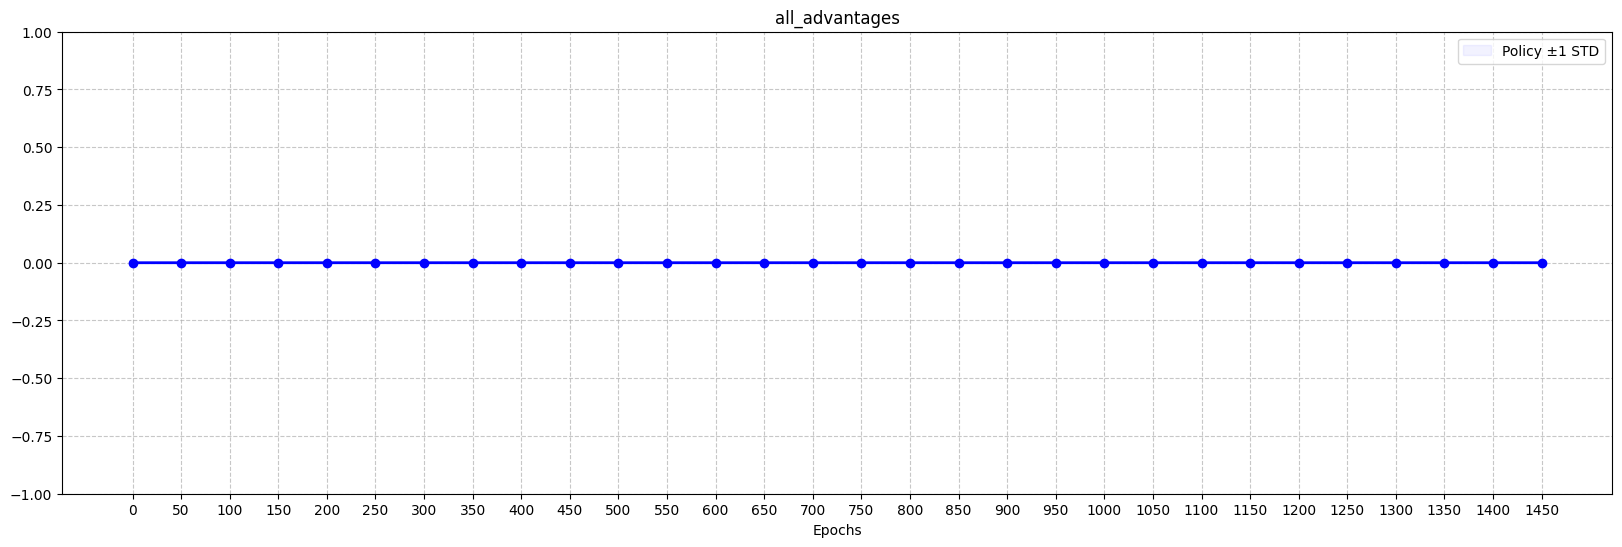

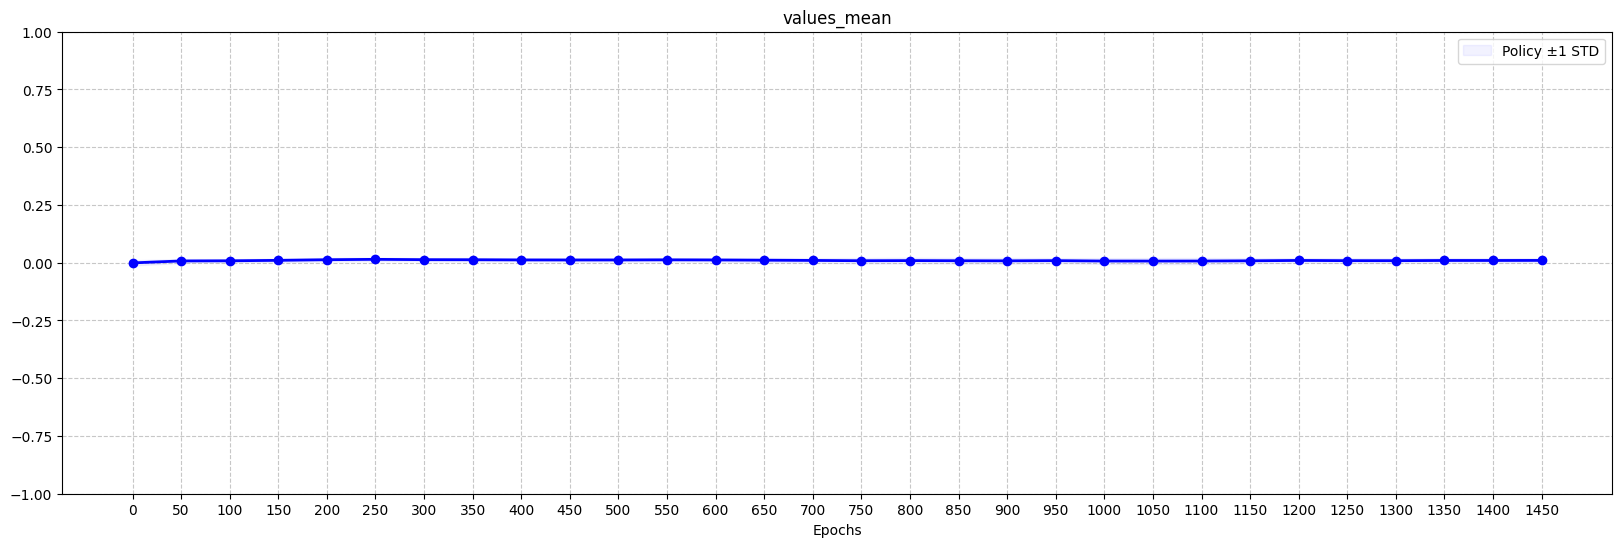

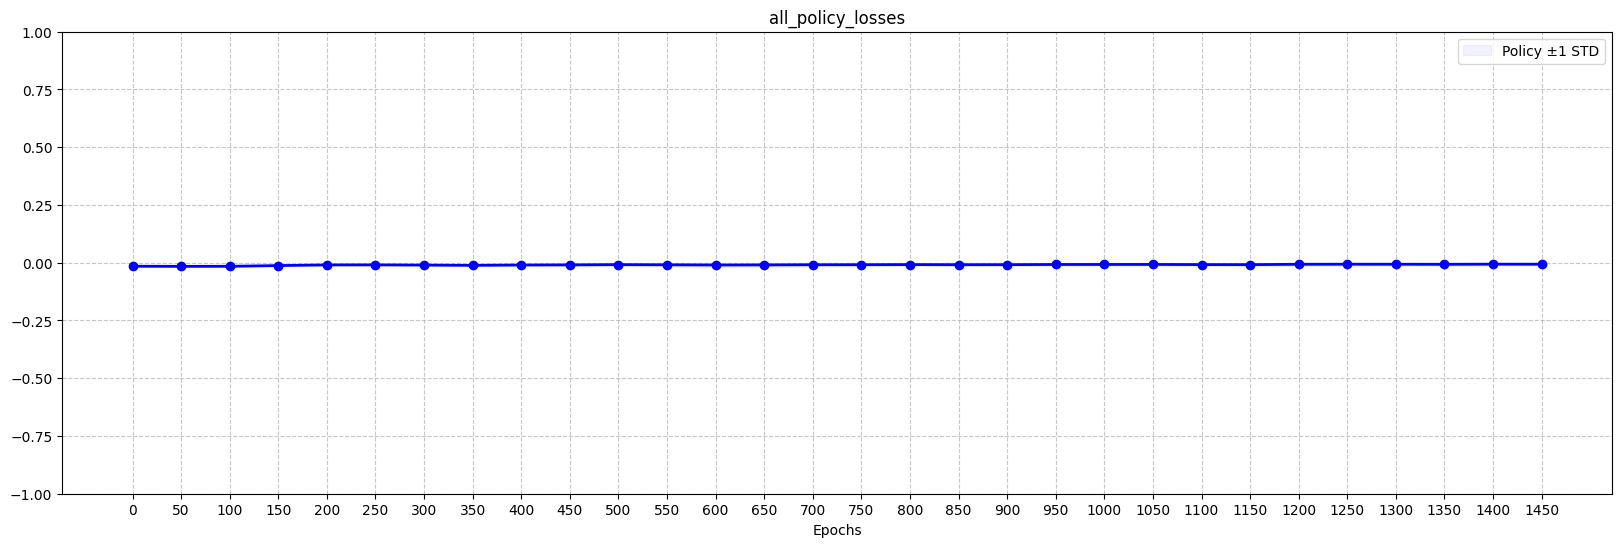

In [27]:
plot_dianostics(avg_df["generator_rewards"], std_df["generator_rewards"],"all_generator_rewards")
plot_dianostics(avg_df["advantages"], std_df["advantages"], "all_advantages")
plot_dianostics(avg_df["value_estimates"], std_df["value_estimates"], "values_mean")
plot_dianostics(avg_df["policy_losses"], std_df["policy_losses"], "all_policy_losses")

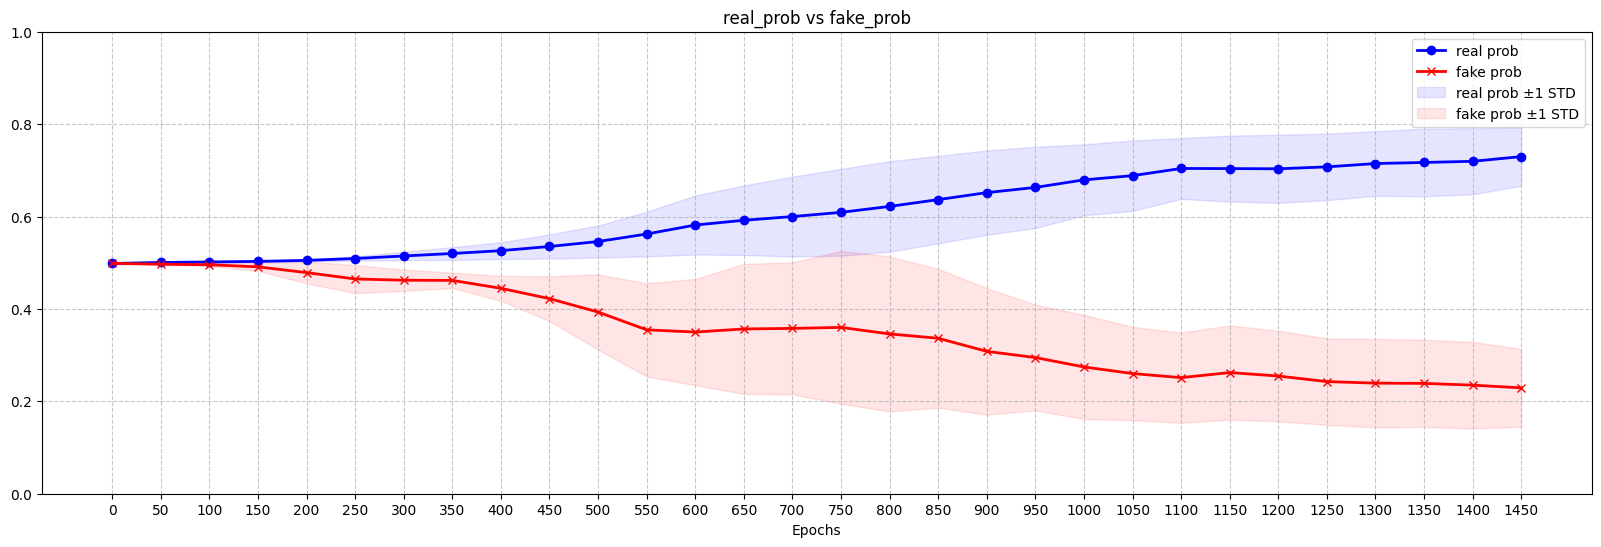

In [28]:
def plot_real_fake_prob(real_prob_means, real_prob_std, fake_prob_means, fake_prob_std, title):
    plt.figure(figsize=(20, 6))

    # Compute windowed means for every 50 epochs (non-overlapping)
    window_size = 50

    # Plot the window-averaged data
    plt.plot(range(0, len(real_prob_means) * window_size, window_size), real_prob_means, color='blue', marker='o', label="real prob", linewidth=2)
    plt.plot(range(0, len(fake_prob_means) * window_size, window_size), fake_prob_means, color='red', marker='x', label="fake prob", linewidth=2)

    # Plot shaded areas for standard deviation
    plt.fill_between(epochs,
                     real_prob_means - real_prob_std,
                     real_prob_means + real_prob_std,
                     alpha=0.1, color='blue', label='real prob ±1 STD')
    plt.fill_between(epochs,
                     fake_prob_means - fake_prob_std,
                     fake_prob_means + fake_prob_std,
                     alpha=0.1, color='red', label='fake prob ±1 STD')

    # Customize the plot
    plt.xlabel('Epochs')
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.xticks(epochs)  # Show epoch numbers on x-axis

    # Fix the y-axis
    plt.ylim(0, 1)

    # Save plot
    os.makedirs("plots", exist_ok=True)
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")
    save_path = f"plots/{DISC_TYPE}_real_fake_prob_{timestamp}.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

    # Display the plot
    plt.show()



plot_real_fake_prob(avg_df["disc_real_prob"], std_df["disc_real_prob"], avg_df["disc_fake_prob"], std_df["disc_fake_prob"], "real_prob vs fake_prob")